# Tweet summary

### Load the data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import logging
from dateutil.parser import parse as date_parse
from utils import tweet_iter, tweet_type
import matplotlib.pyplot as plt


logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Filepaths of the files to load.
filepaths = ['d59d27e2f2ed4778881573df2ecf2fad_001.json.gz',
            '25319652321b4bb498b250ffc53aa0f0_001.json.gz']

def tweet_transform(tweet):
    return {
        'tweet_id': tweet['id_str'], 
        'tweet_created_at': date_parse(tweet['created_at']),
        'user_id': tweet['user']['id_str'],
        'screen_name': tweet['user']['screen_name'],
        'user_created_at': date_parse(tweet['user']['created_at']),
        'tweets_to_date': tweet['user']['statuses_count'],
        'tweet_type': tweet_type(tweet)
    }

tweet_df = pd.DataFrame(tweet_iter(filepaths, tweet_transform_func=tweet_transform), 
                        columns=['tweet_id', 'user_id', 'screen_name', 'tweet_created_at', 
                                 'user_created_at', 'tweets_to_date', 'tweet_type'])
tweet_df.count()

DEBUG:root:Loaded 0
DEBUG:root:Loaded 50000
DEBUG:root:Loaded 100000
DEBUG:root:Loaded 150000
DEBUG:root:Loaded 200000
DEBUG:root:Loaded 250000
DEBUG:root:Loaded 300000
DEBUG:root:Loaded 350000
DEBUG:root:Loaded 400000
DEBUG:root:Loaded 450000
DEBUG:root:Loaded 500000
DEBUG:root:Loaded 550000
DEBUG:root:Loaded 600000
DEBUG:root:Loaded 650000
DEBUG:root:Loaded 700000
DEBUG:root:Loaded 750000
DEBUG:root:Loaded 800000
DEBUG:root:Loaded 850000
DEBUG:root:Loaded 900000
DEBUG:root:Loaded 950000
DEBUG:root:Loaded 1000000
DEBUG:root:Loaded 1050000
DEBUG:root:Loaded 1100000
DEBUG:root:Loaded 1150000
DEBUG:root:Loaded 1200000
DEBUG:root:Loaded 1250000
DEBUG:root:Loaded 1300000
DEBUG:root:Loaded 1350000
DEBUG:root:Loaded 1400000
DEBUG:root:Loaded 1450000
DEBUG:root:Loaded 1500000
DEBUG:root:Loaded 0
DEBUG:root:Loaded 50000
DEBUG:root:Loaded 100000
DEBUG:root:Loaded 150000
DEBUG:root:Loaded 200000
DEBUG:root:Loaded 250000
DEBUG:root:Loaded 300000
DEBUG:root:Loaded 350000
DEBUG:root:Loaded 400000
D

tweet_id            3364440
user_id             3364440
screen_name         3364440
tweet_created_at    3364440
user_created_at     3364440
tweets_to_date      3364440
tweet_type          3364440
dtype: int64

### View the top of the data.

In [2]:
tweet_df.head()

,tweet_id,user_id,screen_name,tweet_created_at,user_created_at,tweets_to_date,tweet_type
0,847821180832804864,1638925448,A_Childers_,2017-03-31 14:41:35+00:00,2013-08-01 21:44:28+00:00,6071,retweet
1,847814632643473411,1638925448,A_Childers_,2017-03-31 14:15:34+00:00,2013-08-01 21:44:28+00:00,6071,retweet
2,847627543142219776,1638925448,A_Childers_,2017-03-31 01:52:09+00:00,2013-08-01 21:44:28+00:00,6071,reply
3,847597404719267841,1638925448,A_Childers_,2017-03-30 23:52:23+00:00,2013-08-01 21:44:28+00:00,6071,reply
4,847593734896324608,1638925448,A_Childers_,2017-03-30 23:37:48+00:00,2013-08-01 21:44:28+00:00,6071,reply


### Remove duplicates
Dupes happen when collecting data from Twitter API and because some reporters may existing in multiple lists.

In [3]:
len(tweet_df['tweet_id'].unique())

3335489

In [4]:
dedupe_tweet_df = tweet_df.drop_duplicates(['tweet_id'], keep='last')
len(dedupe_tweet_df)

3335489

In [5]:
### Create lookup of screen names

In [6]:
# From the tweets, extract map of user ids to screen names
user_id_lookup_df = dedupe_tweet_df.loc[dedupe_tweet_df.groupby('user_id')['tweet_created_at'].idxmax()].ix[:,['user_id', 'screen_name']].set_index(['user_id'])
user_id_lookup_df.count()

screen_name    1443
dtype: int64

In [7]:
user_id_lookup_df.head()

,screen_name
user_id,
100165378,ChristineSisto
1001991865,FredSchulte
1002229862,HMRothmandc
100270054,Laubarth
100802089,ayesharascoe


## Tweets in dataset for each user

In [8]:
tweet_count_df = pd.DataFrame(dedupe_tweet_df['user_id'].value_counts()).rename(columns={'user_id': 'tweets_in_dataset'})
tweet_count_df.index.name = 'user_id'
tweet_count_df.count()

tweets_in_dataset    1443
dtype: int64

### Statistics on number of tweets in dataset for each user <---------------

In [9]:
tweet_count_df.describe()

,tweets_in_dataset
count,1443.000000
mean,2311.496188
std,1259.106696
min,1.000000
25%,1086.000000
50%,3206.000000
75%,3258.000000
max,5286.000000


### Grouping number of tweets in dataset for each user

In [10]:
binned_tweet_count_df = pd.cut(tweet_count_df['tweets_in_dataset'], [0, 10, 100, 250, 500, 1000, 2000, 3000, 4000, 6000])
binned_tweet_count_count_df = pd.DataFrame(binned_tweet_count_df.value_counts()).rename(columns={'tweets_in_dataset': 'user_count'}).sort_index() 
binned_tweet_count_count_df


,user_count
"(0, 10]",28
"(10, 100]",63
"(100, 250]",70
"(250, 500]",81
"(500, 1000]",107
"(1000, 2000]",162
"(2000, 3000]",121
"(3000, 4000]",807
"(4000, 6000]",4


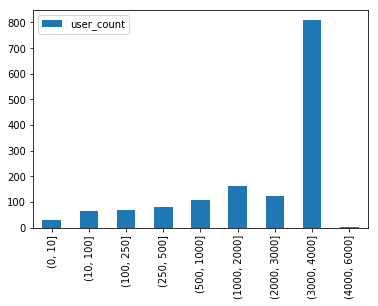

In [11]:
binned_tweet_count_count_df.plot(kind='bar')

In [12]:
# Get the first tweet for each user
first_tweet_df = dedupe_tweet_df.loc[dedupe_tweet_df.groupby('user_id')['tweet_created_at'].idxmin()].set_index(['user_id'])
first_tweet_df.count()

tweet_id            1443
screen_name         1443
tweet_created_at    1443
user_created_at     1443
tweets_to_date      1443
tweet_type          1443
dtype: int64

In [13]:
first_tweet_df.head()

,tweet_id,screen_name,tweet_created_at,user_created_at,tweets_to_date,tweet_type
user_id,,,,,,
100165378,619906732052074496,ChristineSisto,2015-07-11 16:30:56+00:00,2009-12-29 07:27:27+00:00,8646,retweet
1001991865,289090058148012033,FredSchulte,2013-01-09 19:23:35+00:00,2012-12-10 16:16:10+00:00,888,reply
1002229862,425802092465623040,HMRothmandc,2014-01-22 01:28:24+00:00,2012-12-10 18:37:13+00:00,1777,reply
100270054,740945974143635464,Laubarth,2016-06-09 16:37:41+00:00,2009-12-29 17:02:01+00:00,6,original
100802089,7240989598,ayesharascoe,2009-12-31 17:27:25+00:00,2009-12-31 16:48:11+00:00,491,original


In [14]:
# Merge with number of tweets in dataset for each user
first_tweet_merge_df = first_tweet_df.join(tweet_count_df).drop(['tweet_id', 'tweet_type'], axis=1)
first_tweet_merge_df.count()

screen_name          1443
tweet_created_at     1443
user_created_at      1443
tweets_to_date       1443
tweets_in_dataset    1443
dtype: int64

## First tweet for each user  <----------
For each user, the date of the first tweet in the dataset, the date the account was created, the number of tweets to date (roughly), and the tweets in the dataset.

If the user_created_at and tweet_created_at are close, then this is probably a new account.
If the user_created_at and tweet_created_at are not close, but there is a small number of tweets then this user probably started tweeting recently (like a new account).
If the user_created_at and tweet_created_at are not close and there is a large number of tweets then this is probably a prolific tweeter. Note that not all tweets for this user were probably collected.

In [15]:
first_tweet_merge_df.sort_values('tweet_created_at', ascending=False).head(20)

,screen_name,tweet_created_at,user_created_at,tweets_to_date,tweets_in_dataset
user_id,,,,,
76696176,sklee_ca,2017-03-31 17:07:58+00:00,2009-09-23 17:09:53+00:00,2,2
66768858,emmaroller,2017-03-27 13:25:07+00:00,2009-08-18 19:10:55+00:00,223,210
842787331224584192,RebeccaEHoffman,2017-03-17 17:27:58+00:00,2017-03-17 17:18:52+00:00,9,9
831972200014045191,ErinMcManus15,2017-03-15 14:16:31+00:00,2017-02-15 21:03:24+00:00,1,1
20281013,EvanMcS,2017-03-10 16:33:43+00:00,2009-02-06 23:09:59+00:00,146,196
18825339,CahnEmily,2017-03-10 13:43:41+00:00,2009-01-10 03:19:50+00:00,86548,3205
30176025,LaurenFCarroll,2017-03-08 20:33:21+00:00,2009-04-10 06:29:32+00:00,34,49
3817401,ericgeller,2017-03-07 16:38:59+00:00,2007-04-08 20:27:11+00:00,186181,5286
21612122,HotlineJosh,2017-03-03 22:00:52+00:00,2009-02-22 23:45:46+00:00,143393,3227


### New users

In [16]:
from datetime import datetime
start_date = datetime(2017, 1, 1)
end_date = datetime(2017, 4, 1)

first_tweet_merge_df['new_user'] = first_tweet_merge_df.user_created_at > start_date
first_tweet_merge_df['new_user'].value_counts()

False    1438
True        5
Name: new_user, dtype: int64

In [17]:
first_tweet_merge_df[first_tweet_merge_df.new_user == True]

,screen_name,tweet_created_at,user_created_at,tweets_to_date,tweets_in_dataset,new_user
user_id,,,,,,
826808800921403393,ToporHCF,2017-02-01 15:30:41+00:00,2017-02-01 15:05:54+00:00,7,10,True
827605131109793792,OSHAReporter,2017-02-08 21:50:54+00:00,2017-02-03 19:50:14+00:00,99,114,True
831972200014045191,ErinMcManus15,2017-03-15 14:16:31+00:00,2017-02-15 21:03:24+00:00,1,1,True
836643030161625089,BeddingfieldMJ,2017-02-28 19:00:31+00:00,2017-02-28 18:23:37+00:00,5,5,True
842787331224584192,RebeccaEHoffman,2017-03-17 17:27:58+00:00,2017-03-17 17:18:52+00:00,9,9,True


### Prolific users
Prolific users have more than 3,000 tweets and first tweet is after start date.

In [18]:
first_tweet_merge_df['prolific_user'] = (first_tweet_merge_df.tweets_in_dataset > 3000) & (first_tweet_merge_df.tweet_created_at > start_date)
first_tweet_merge_df['prolific_user'].value_counts()

False    1403
True       40
Name: prolific_user, dtype: int64

In [19]:
first_tweet_merge_df[first_tweet_merge_df.prolific_user == True]

,screen_name,tweet_created_at,user_created_at,tweets_to_date,tweets_in_dataset,new_user,prolific_user
user_id,,,,,,,
102171691,rlocker12,2017-01-16 10:53:43+00:00,2010-01-05 21:36:39+00:00,36181,3757,False,True
103016675,AaronMehta,2017-02-16 19:05:49+00:00,2010-01-08 15:53:25+00:00,37425,3242,False,True
104299137,DavidMDrucker,2017-01-23 10:47:25+00:00,2010-01-12 22:56:50+00:00,95820,3846,False,True
11702412,VickoftheHill,2017-01-12 23:33:55+00:00,2008-01-01 00:10:51+00:00,10985,3217,False,True
11771512,OKnox,2017-01-12 16:20:48+00:00,2008-01-02 20:58:16+00:00,90724,3633,False,True
118130765,dylanlscott,2017-01-29 22:45:57+00:00,2010-02-27 18:03:36+00:00,36271,3241,False,True
12134692,MikeMadden,2017-01-21 20:44:35+00:00,2008-01-11 22:43:03+00:00,79202,3720,False,True
12245632,jackshafer,2017-01-21 19:35:42+00:00,2008-01-15 00:39:38+00:00,40041,3241,False,True
13524182,daveweigel,2017-02-09 21:56:58+00:00,2008-02-15 17:58:23+00:00,160812,3846,False,True


## First tweet for each user, removing new users and prolific users

In [20]:
limited_first_tweet_merge_df = first_tweet_merge_df[(first_tweet_merge_df.prolific_user == False) & (first_tweet_merge_df.new_user == False)]
limited_first_tweet_merge_df[['screen_name', 'tweet_created_at', 'user_created_at', 'tweets_to_date', 'tweets_in_dataset']].sort_values('tweet_created_at', ascending=False).head(20)

,screen_name,tweet_created_at,user_created_at,tweets_to_date,tweets_in_dataset
user_id,,,,,
76696176,sklee_ca,2017-03-31 17:07:58+00:00,2009-09-23 17:09:53+00:00,2,2
66768858,emmaroller,2017-03-27 13:25:07+00:00,2009-08-18 19:10:55+00:00,223,210
20281013,EvanMcS,2017-03-10 16:33:43+00:00,2009-02-06 23:09:59+00:00,146,196
30176025,LaurenFCarroll,2017-03-08 20:33:21+00:00,2009-04-10 06:29:32+00:00,34,49
19195094,RebeccaShabad,2016-12-23 22:21:56+00:00,2009-01-19 18:38:52+00:00,71933,3245
353866329,mVespa1,2016-12-22 16:58:43+00:00,2011-08-12 19:20:14+00:00,71141,3222
46955476,GrahamDavidA,2016-12-21 00:51:22+00:00,2009-06-13 20:18:33+00:00,89770,3704
19038768,DefenseBaron,2016-12-20 17:55:31+00:00,2009-01-15 20:59:03+00:00,52374,3639
21579498,andrewperezdc,2016-12-20 05:48:07+00:00,2009-02-22 17:16:51+00:00,16540,3660


## Types of tweets <----------
While all the tweets are loaded, summarize the types of tweets.

In [21]:
dedupe_tweet_df['tweet_type'].value_counts()

original    1593541
retweet     1094028
reply        396287
quote        251633
Name: tweet_type, dtype: int64

In [22]:
pd.qcut(tweet_count_df.tweets_in_dataset, 10).value_counts(sort=False)

[1, 209.2]          145
(209.2, 689]        144
(689, 1524.6]       144
(1524.6, 2509.4]    144
(2509.4, 3206]      152
(3206, 3227]        145
(3227, 3244]        137
(3244, 3282]        146
(3282, 3347.8]      141
(3347.8, 5286]      145
Name: tweets_in_dataset, dtype: int64

## Middle 80%
Drop 10% least and most prolific tweeters

In [23]:
tweet_count_qcut = pd.qcut(tweet_count_df.tweets_in_dataset, [0, .1, .9, 1.])
tweet_count_qcut.value_counts(sort=False)

[1, 209.2]          145
(209.2, 3347.8]    1153
(3347.8, 5286]      145
Name: tweets_in_dataset, dtype: int64